In [1]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [2]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [3]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

def get_average_protein_no_delta(path, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    #tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [ ]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = 10
ribosome_copy_numbers = [5, 25, 100, 500, 2000, 10000]
total_trna = 2500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [10000.0, 30000.0, 100000.0, 300000.0, 1000000.0, 3000000.0]
trna_charging_rate = 300.0
#trna_charging_rates = [30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
ecol_mrna_composition = (0.6, 0.4) # Making e. coli codon usage less optimal
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
ribosome_speed = 3
ribosome_footprint = 15

date = "march-22-2024"

In [5]:
!mkdir ../output/march-22-2024
!mkdir ../yaml/march-22-2024

In [6]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [10]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for ribosome_copy_number in ribosome_copy_numbers:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [77]:
ribosome_binding_rates = [10000.0, 30000.0, 100000.0, 300000.0, 1000000.0, 3000000.0]
ribosome_copy_numbers = [5, 25, 100, 500, 2000]
#gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
gfp_mrna_compositions = [(0.9, 0.1), (0.3, 0.7), (0.7, 0.3), (0.1, 0.9)]
df_master = None

for ribosome_cp in ribosome_copy_numbers:
    df_rib = None
    for binding_rate in ribosome_binding_rates:
        df_binding = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_0.6_0.4_{codons[0]}_{codons[1]}_0.7_0.3" + \
                   f"_{cellular_transcript_copy_number}_{gfp_transcript_copy_number}_{ribosome_cp}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_binding is not None:
                df_binding = df_binding.append(tmp, ignore_index=True)
            else:
                df_binding = tmp
        df_binding["gfp_rbs"] = binding_rate
        if df_rib is not None:
            df_rib = df_rib.append(df_binding, ignore_index=True)
        else:
            df_rib = df_binding
    df_rib["ribosome_copy"] = ribosome_cp
    if df_master is not None:
        df_master = df_master.append(df_rib, ignore_index=True)
    else:
        df_master = df_rib`

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_1158306/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()


In [78]:
df_master

,time,species,protein,ribo_density,delta,codon,gfp_rbs,ribosome_copy
9,200.0,ATA_charged,737.000000,0.000000,-3.000000,0.9,10000.0,5
10,200.0,ATA_uncharged,13.000000,0.000000,3.000000,0.9,10000.0,5
11,200.0,GFP,3.000000,0.000000,0.500000,0.9,10000.0,5
12,200.0,TTT_charged,1733.000000,0.000000,7.000000,0.9,10000.0,5
13,200.0,TTT_uncharged,17.000000,0.000000,-7.000000,0.9,10000.0,5
...,...,...,...,...,...,...,...,...
2101,200.0,TTT_uncharged,947.000000,0.000000,-10.666667,0.1,3000000.0,2000
2102,200.0,__GFP_rbs,4.333333,0.000000,-0.666667,0.1,3000000.0,2000
2103,200.0,__cellularProtein_rbs,82.000000,0.000000,-4.333333,0.1,3000000.0,2000
2104,200.0,free ribosome,256.666667,0.000000,-17.333333,0.1,3000000.0,2000


In [106]:
df_master = df_master[(df_master.ribosome_copy != 5)]
df_master["gfp_rbs_foldx"] = df_master["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df_master.pivot_table(index=['gfp_rbs_foldx', 'codon', 'ribosome_copy'], columns='species', values='protein').reset_index()

#df["TTT_charged"] = df["TTT_charged"] / (total_trna*0.7)
#df["ATA_charged"] = df["ATA_charged"] / (total_trna*0.3)
#df["free ribosome"] = df["free ribosome"] / ribosome_copy_number

df['cellularProtein_max'] = df.groupby(['codon', 'ribosome_copy'])['cellularProtein'].transform('max')
df['cellularProtein_norm'] = df['cellularProtein']/df["cellularProtein_max"]

/tmp/ipykernel_1158306/3599856749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["gfp_rbs_foldx"] = df_master["gfp_rbs"] / ecol_rbs_rate


In [107]:
df

species,gfp_rbs_foldx,codon,ribosome_copy,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,cellularProtein_max,cellularProtein_norm
0,0.1,0.1,25,718.666667,31.333333,7.333333,1701.666667,48.333333,10.000000,100.000000,6312.333333,17.000000,6312.333333,1.000000
1,0.1,0.1,100,600.333333,149.666667,24.000000,1519.000000,231.000000,10.000000,99.666667,23599.666667,57.000000,23599.666667,1.000000
2,0.1,0.1,500,227.333333,522.666667,76.333333,961.333333,788.666667,10.000000,97.666667,77629.666667,182.333333,77629.666667,1.000000
3,0.1,0.1,2000,55.666667,694.333333,126.666667,686.333333,1063.666667,10.000000,86.666667,104434.666667,299.333333,104434.666667,1.000000
4,0.1,0.3,25,707.666667,42.333333,6.333333,1678.333333,71.666667,10.000000,100.000000,6309.000000,14.666667,6309.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,30.0,0.7,500,236.000000,514.000000,21830.000000,928.666667,821.333333,9.666667,96.333333,73305.666667,184.000000,77686.666667,0.943607
86,30.0,0.9,25,707.666667,42.333333,1858.666667,1670.000000,80.000000,9.666667,100.000000,6144.666667,13.333333,6324.000000,0.971642
87,30.0,0.9,100,599.333333,150.666667,6793.333333,1482.000000,268.000000,10.000000,100.000000,23002.666667,54.666667,23609.000000,0.974318
88,30.0,0.9,500,238.333333,511.666667,22079.333333,904.000000,846.000000,10.000000,98.666667,75180.333333,192.666667,77722.000000,0.967298


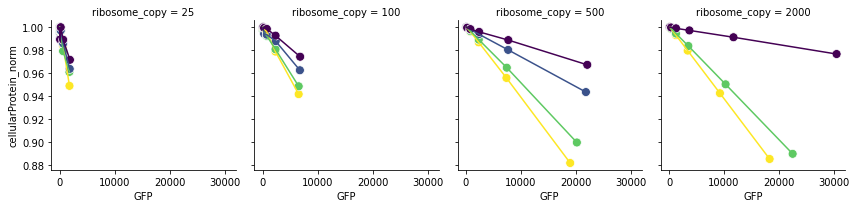

In [130]:
g = sns.FacetGrid(df, col="ribosome_copy", col_wrap=4)
g.map_dataframe(sns.scatterplot, x="GFP", y="cellularProtein_norm", hue = "codon", s=80, palette="viridis_r")
g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")

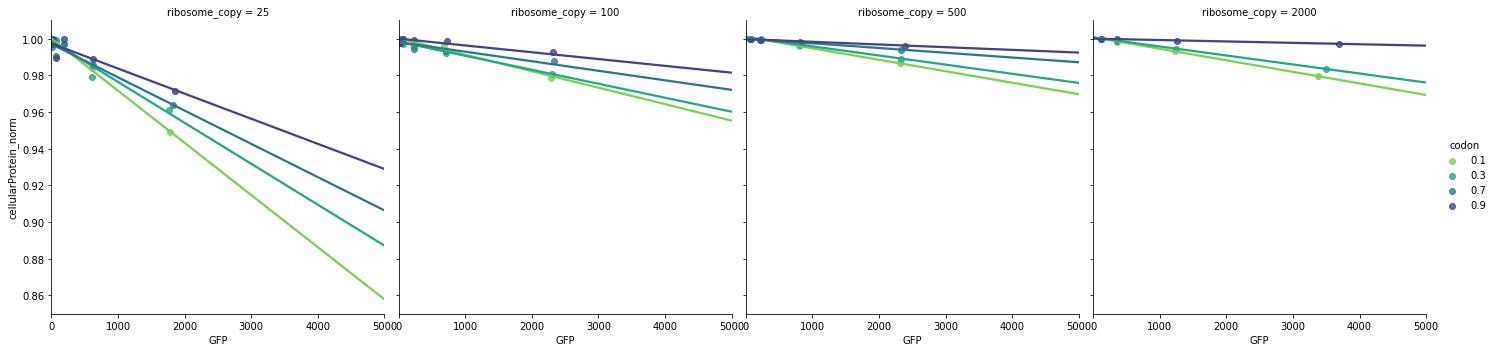

In [134]:
#g = sns.FacetGrid(df, col="ribosome_copy", col_wrap=4)
#g.map_dataframe(sns.scatterplot, x="GFP", y="cellularProtein_norm", hue = "codon", s=80, palette="viridis_r")
#g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")
g = sns.lmplot(data=df, x="GFP", y="cellularProtein_norm", hue="codon", col="ribosome_copy", palette="viridis_r", ci=None, truncate=False)
g.set(xlim=(0, 5000))
g.set(ylim=(0.85, 1.01))

In [82]:
df.to_csv("regression_rib_copy.csv")

In [109]:
df["TTT_charged"] = df["TTT_charged"] / (total_trna*0.7)
df["ATA_charged"] = df["ATA_charged"] / (total_trna*0.3)
#df["free ribosome"] = df["free ribosome"] / ribosome_copy_number


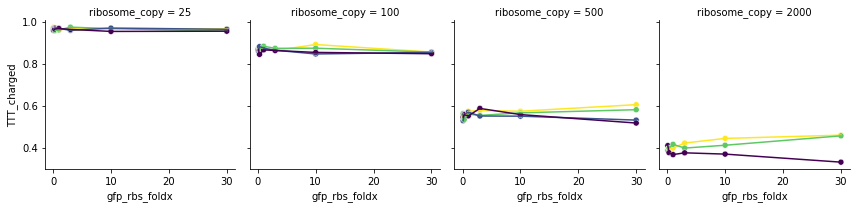

In [110]:
g = sns.FacetGrid(df, col="ribosome_copy")
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="TTT_charged", hue = "codon", palette="viridis_r")
g.map_dataframe(sns.lineplot, x="gfp_rbs_foldx", y="TTT_charged", hue = "codon", palette="viridis_r")
#g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")

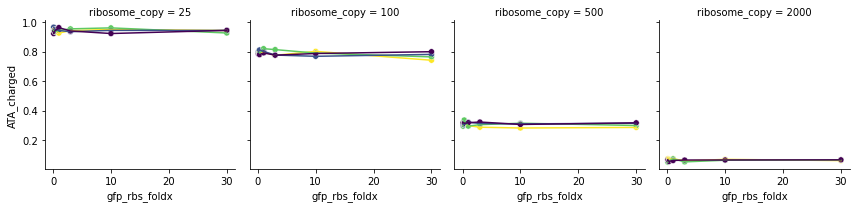

In [111]:
g = sns.FacetGrid(df, col="ribosome_copy")
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="ATA_charged", hue = "codon", palette="viridis_r")
g.map_dataframe(sns.lineplot, x="gfp_rbs_foldx", y="ATA_charged", hue = "codon", palette="viridis_r")
#g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")

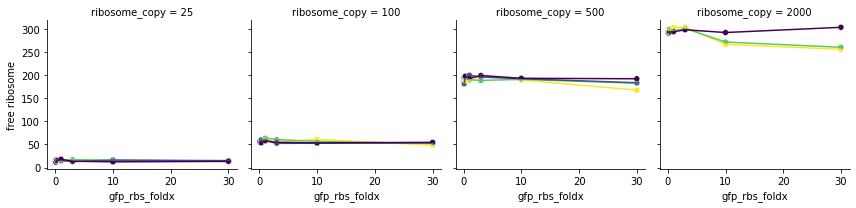

In [112]:
g = sns.FacetGrid(df, col="ribosome_copy")
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="free ribosome", hue = "codon", palette="viridis_r")
g.map_dataframe(sns.lineplot, x="gfp_rbs_foldx", y="free ribosome", hue = "codon", palette="viridis_r")
#g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")

In [113]:
df_ribo = df_master.copy()
df_ribo["gfp_rbs_foldx"] = df_ribo["gfp_rbs"] / ecol_rbs_rate
df_ribo = df_ribo.pivot_table(index=['gfp_rbs_foldx', 'codon', 'ribosome_copy'], columns='species', values='ribo_density').reset_index()
df_ribo["cell_ribo_usage"] = df_ribo["cellularProtein"] / df_ribo["ribosome_copy"] * cellular_transcript_copy_number
df_ribo["gfp_ribo_usage"] = df_ribo["GFP"] / df_ribo["ribosome_copy"] * gfp_transcript_copy_number

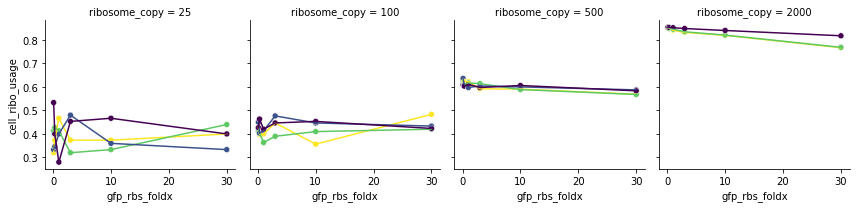

In [114]:
g = sns.FacetGrid(df_ribo, col="ribosome_copy")
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="cell_ribo_usage", hue = "codon", palette="viridis_r")
g.map_dataframe(sns.lineplot, x="gfp_rbs_foldx", y="cell_ribo_usage", hue = "codon", palette="viridis_r")
#g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")

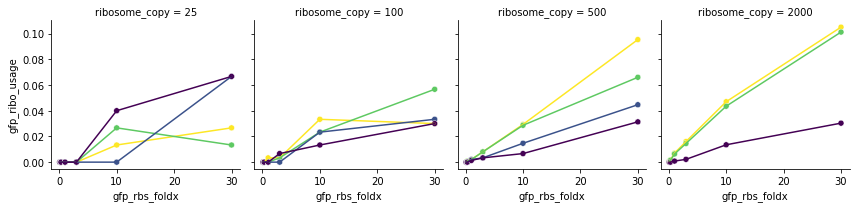

In [115]:
g = sns.FacetGrid(df_ribo, col="ribosome_copy")
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="gfp_ribo_usage", hue = "codon", palette="viridis_r")
g.map_dataframe(sns.lineplot, x="gfp_rbs_foldx", y="gfp_ribo_usage", hue = "codon", palette="viridis_r")
#g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")